## Image Classification with CNN for Malaria Data

In this project, we have a malaria dataset. I solved this project using colab notebook on kaggle.



This is an image classification project solved with a cnn (convolutional neural network).

1)Dataset: The malaria dataset consists of microscopic blood smear images belonging to two classes: Uninfected and Parasitized. It contains hundreds of images for each class.

2)Data Preprocessing: The images have been preprocessed, including normalizing the image sizes, handling color channels, and applying data augmentation techniques as needed.

3)Model Architecture: A convolutional neural network (CNN) model has been built using libraries like Keras or TensorFlow. The model architecture comprises convolutional layers, pooling layers, fully connected layers, and activation functions.

4)Training and Evaluation: The constructed model has been trained on the malaria dataset. The model's performance has been evaluated using metrics such as accuracy, precision, recall, and F1-score.

5)Results: The trained model is able to successfully distinguish between the Uninfected and Parasitized classes. The project results can provide an automated and fast solution for malaria diagnosis.

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'cell-images-for-detecting-malaria:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F87153%2F200743%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240807%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240807T204759Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D0c8188cfe5e72ec214e8585bfbadba86da51c3a0c6f560cc62c37417bbbef449f78be71bf45cfc0a2afab2ca01f47b51fb2b7b80c228afe6aba048dfd2dcf3c25a1ec98fd6726ce602a1d9bbb909f8bf7d408965f4b9b2e879dfdc354c45904e26e87e01a320066f3ee037d268cef88e495c027cce3f798e991d82037a152cd6d8ca6f5ce19f81b53d9b2767881bfc23fc8e51e2cbb3f7c270d1e4691048233e23127014af8dcd428bbecf0f9f403102fda65f37b200aa2b158800f166386981f14c8371f8d97999b654a9241fff0549c96b9e27bdce4ea1dd30f1daf7a756d23af070f51e4a6d979d177cf518e5f61d5baa2d3978066359dc4279b70385cb69'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

#This part comes when we want to open and work on Colab Notebook via Kaggle. When we run it, our dataset is downloaded into the notebook.


[==================================================] 708172590 bytes downloaded
Downloaded and uncompressed: cell-images-for-detecting-malaria
Data source import complete.


### Import Packages

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Input, Reshape, MaxPooling2D, Flatten, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from IPython.display import Image
from google.colab.patches import cv2_imshow
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Görüntülenen çıkış son 5000 satıra kısaltıldı.
/kaggle/input/cell-images-for-detecting-malaria/cell_images/cell_images/Uninfected/C216ThinF_IMG_20151106_135337_cell_145.png
/kaggle/input/cell-images-for-detecting-malaria/cell_images/cell_images/Uninfected/C125P86ThinF_IMG_20151004_102013_cell_37.png
/kaggle/input/cell-images-for-detecting-malaria/cell_images/cell_images/Uninfected/C142P103ThinF_IMG_20151005_222255_cell_29.png
/kaggle/input/cell-images-for-detecting-malaria/cell_images/cell_images/Uninfected/C182P143NThinF_IMG_20151201_171836_cell_16.png
/kaggle/input/cell-images-for-detecting-malaria/cell_images/cell_images/Uninfected/C127P88ThinF_IMG_20151004_111651_cell_68.png
/kaggle/input/cell-images-for-detecting-malaria/cell_images/cell_images/Uninfected/C186P147NThinF_IMG_20151203_150322_cell_110.png
/kaggle/input/cell-images-for-detecting-malaria/cell_images/cell_images/Uninfected/C201ThinF_IMG_20150930_142848_cell_106.png
/kaggle/input/cell-images-for-detecting-malaria/cell_im

### We determine our file path.

In [ ]:
print(os.listdir("/kaggle/input/cell-images-for-detecting-malaria/cell_images/"))
#There is another same folder inside the first cell images folder.

['Parasitized', 'Uninfected', 'cell_images']


In [ ]:
print(os.listdir("/kaggle/input/cell-images-for-detecting-malaria/cell_images/cell_images/"))
#So we read our file like this.

['Parasitized', 'Uninfected']


### Different Ways to Display Images

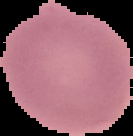

In [ ]:
input=cv2.imread('/kaggle/input/cell-images-for-detecting-malaria/cell_images/Uninfected/C80P41ThinF_IMG_20150817_111246_cell_104.png')
cv2_imshow(input)
#Uninfected Cell

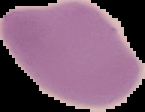

In [ ]:
Image('/kaggle/input/cell-images-for-detecting-malaria/cell_images/Uninfected/C7NthinF_IMG_20150611_104753_cell_57.png')
#Uninfected cell

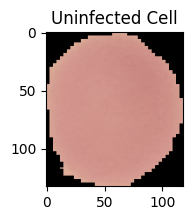

In [ ]:
u='/kaggle/input/cell-images-for-detecting-malaria/cell_images/Uninfected/C107P68ThinF_IMG_20150924_222415_cell_23.png'
plt.figure(figsize=(2,2))
plt.imshow(plt.imread(u))
plt.title('Uninfected Cell')
plt.show()

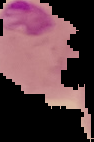

In [ ]:
input=cv2.imread('/kaggle/input/cell-images-for-detecting-malaria/cell_images/Parasitized/C82P43ThinF_IMG_20150817_124418_cell_173.png')
cv2_imshow(input)
#Parasizited Cell

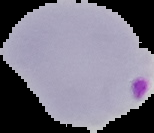

In [ ]:
Image('/kaggle/input/cell-images-for-detecting-malaria/cell_images/Parasitized/C179P140ThinF_IMG_20151127_153350_cell_182.png')
#Parasizited cell

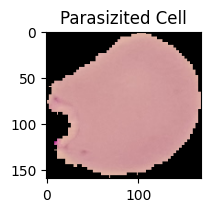

In [ ]:
p='/kaggle/input/cell-images-for-detecting-malaria/cell_images/Parasitized/C68P29N_ThinF_IMG_20150819_134504_cell_132.png'
plt.figure(figsize=(2,2))
plt.imshow(plt.imread(p))
plt.title('Parasizited Cell')
plt.show()

### We start reading the pictures.

In [ ]:
labels=['Uninfected','Parasitized']
img_path="/kaggle/input/cell-images-for-detecting-malaria/cell_images/cell_images/"

In [ ]:
img_list=[]
label_list=[]

for label in labels:
    for img_file in os.listdir(img_path+label):
        # Check if the file is an image file
        if img_file.endswith(('.jpg', '.jpeg', '.png')):
            img_list.append(img_path+label+'/'+img_file)
            label_list.append(label)


In [ ]:
df=pd.DataFrame({'img':img_list,'label':label_list})
#We saved it to data frame.

In [ ]:
df.head()
#We check that our data is correct.

,img,label
0,/kaggle/input/cell-images-for-detecting-malari...,Uninfected
1,/kaggle/input/cell-images-for-detecting-malari...,Uninfected
2,/kaggle/input/cell-images-for-detecting-malari...,Uninfected
3,/kaggle/input/cell-images-for-detecting-malari...,Uninfected
4,/kaggle/input/cell-images-for-detecting-malari...,Uninfected


In [ ]:
df.tail()

,img,label
27553,/kaggle/input/cell-images-for-detecting-malari...,Parasitized
27554,/kaggle/input/cell-images-for-detecting-malari...,Parasitized
27555,/kaggle/input/cell-images-for-detecting-malari...,Parasitized
27556,/kaggle/input/cell-images-for-detecting-malari...,Parasitized
27557,/kaggle/input/cell-images-for-detecting-malari...,Parasitized


### Label Encoding

In [ ]:
d={'Parasitized':1, 'Uninfected':0}
#We perform label encoding by giving 1 to those infected and 0 to those not infected.

In [ ]:
df['encode_label']=df['label'].map(d)
#We define what we encode by creating a new column.

In [ ]:
df.sample(5)

,img,label,encode_label
11647,/kaggle/input/cell-images-for-detecting-malari...,Uninfected,0
26338,/kaggle/input/cell-images-for-detecting-malari...,Parasitized,1
17794,/kaggle/input/cell-images-for-detecting-malari...,Parasitized,1
17668,/kaggle/input/cell-images-for-detecting-malari...,Parasitized,1
15560,/kaggle/input/cell-images-for-detecting-malari...,Parasitized,1


In [ ]:
x=[]

for img in df['img']:
    img=cv2.imread(img)
    img=cv2.resize(img,(32,32))
    img=img/255.0
    x.append(img)

In [ ]:
x=np.array(x)
#We defined x.

In [ ]:
y=df['encode_label']
#We defined y.

In [ ]:
print(len(x))
print(len(y))
#We check the lengths of x and y.

27558
27558


## Modelling

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.20,random_state=42)

In [ ]:
model=Sequential()
model.add(Input(shape=(32,32,3)))
model.add(Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128))
model.add(Dense(2,activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])


In [ ]:
early_stopping = EarlyStopping(patience=5,verbose=1)

history=model.fit(x_train,y_train,epochs=15,verbose=1,validation_data=(x_test,y_test),callbacks=[early_stopping])


Epoch 1/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 37s 51ms/step - accuracy: 0.6266 - loss: 0.6444 - val_accuracy: 0.7810 - val_loss: 0.4456
Epoch 2/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 33s 48ms/step - accuracy: 0.8635 - loss: 0.3220 - val_accuracy: 0.9325 - val_loss: 0.1833
Epoch 3/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 32s 47ms/step - accuracy: 0.9467 - loss: 0.1540 - val_accuracy: 0.9407 - val_loss: 0.1650
Epoch 4/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 40s 46ms/step - accuracy: 0.9524 - loss: 0.1422 - val_accuracy: 0.9459 - val_loss: 0.1613
Epoch 5/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - accuracy: 0.9514 - loss: 0.1406 - val_accuracy: 0.9389 - val_loss: 0.1692
Epoch 6/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 35s 50ms/step - accuracy: 0.9564 - loss: 0.1270 - val_accuracy: 0.9456 - val_loss: 0.1589
Epoch 7/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 43s 53ms/step - accuracy: 0.9562 - loss: 0.1321 - val_accuracy: 0.9351 - val_loss: 0.1776
Epoch 8/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 36s 46ms/step - accuracy: 0.9529 - loss: 0.1300 - 

In [ ]:
loss,accuracy=model.evaluate(x_test, y_test)

173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9319 - loss: 0.1948


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 944,072 (3.60 MB)

 Trainable params: 314,690 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 629,382 (2.40 MB)

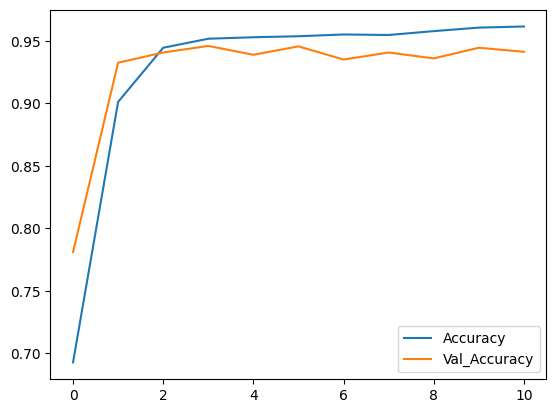

In [ ]:
plt.plot(history.history['accuracy'],label='Accuracy')
plt.plot(history.history['val_accuracy'],label='Val_Accuracy')
plt.legend()

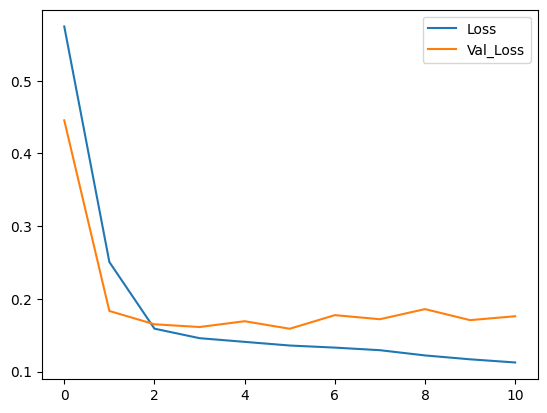

In [ ]:
plt.plot(history.history['loss'],label='Loss')
plt.plot(history.history['val_loss'],label='Val_Loss')
plt.legend()

In [ ]:
pred=model.predict(x_test)

173/173 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step


In [ ]:
confusion_matrix(y_test,np.argmax(pred,axis=1))

array([[2721,   76],
       [ 248, 2467]])

In [ ]:
print(classification_report(y_test, np.argmax(pred,axis=1)))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94      2797
           1       0.97      0.91      0.94      2715

    accuracy                           0.94      5512
   macro avg       0.94      0.94      0.94      5512
weighted avg       0.94      0.94      0.94      5512



<Axes: >

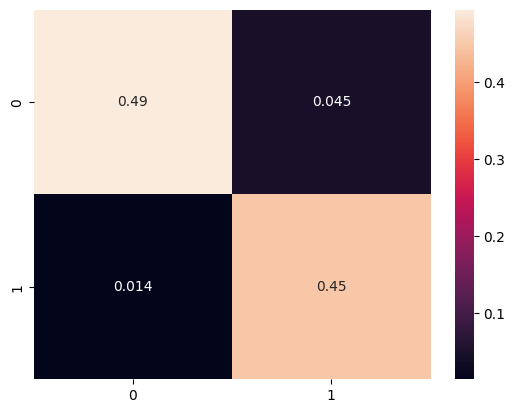

In [ ]:
cm = confusion_matrix(np.argmax(pred,axis=1), y_test)
normalized_cm = cm / cm.sum()
sns.heatmap(normalized_cm, annot=True)

In [ ]:
model.save('malaria_model.h5')
#We save our model.

When we look at our success rate, our train data predicted around 96 percent and our test data predicted around 94 percent correctly. Our other success rates are also good. Our model has been trained successfully.